# **Digit Recognizer with Logistic Regression**

### **Content**
* [1 Load Dataset and Data Exploration](#0)
* [2 Binary Classification](#1)
* [3 Multi-class Classification](#2)
* [Conclusion](#10)

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse
import time
%matplotlib inline
from PIL import Image 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report

<a id="0"></a> 
# 1 Load Dataset and Data Exploration

In [0]:
def load_mnist(path, kind = 'train'):
    """load dataset"""    
    import os
    import gzip
    import numpy as np

    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [0]:
# load in packages 
load_mnist
%reload_ext autoreload
%autoreload 2

In [0]:
# MNIST
images_tr, labels_tr= load_mnist('MNIST/')
images_tst, labels_tst = load_mnist('MNIST/', 't10k')
# FASHION
# images_tr, labels_tr = load_mnist('FashionMNIST/')
# images_tst, labels_tst = load_mnist('FashionMNIST/', 't10k')

In [0]:
def build_model_data(images, labels):
    """get regression data(training set) in matrix form"""
    y = labels
    y = np.expand_dims(y, axis=1)
    x = images
    num_samples = len(y)
    tx = np.c_[np.ones(num_samples), x]
    
    return y, tx

In [0]:
# training set
# normalization 
x = images_tr/255 + 0.0001
y, tx = build_model_data(images_tr, labels_tr)
# test set
x_tst = images_tst
y_tst, tx_tst = build_model_data(images_tst, labels_tst)

In [0]:
x.shape, y.shape,

((60000, 784), (60000, 1))

In [0]:
x_tst.shape, y_tst.shape

((10000, 784), (10000, 1))

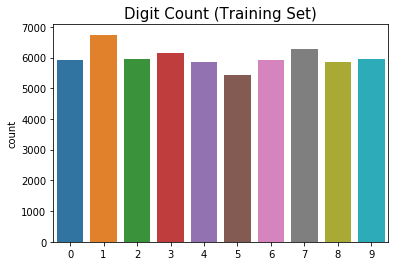

In [0]:
# Visualization of labels count in training set
sns.countplot(labels_tr)
plt.title('Digit Count (Training Set)',  fontsize = 15)
plt.show()

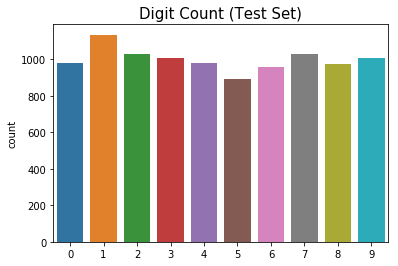

In [0]:
# Visualization of labels count in test set
sns.countplot(labels_tst)
plt.title('Digit Count (Test Set)',  fontsize = 15)
plt.show()

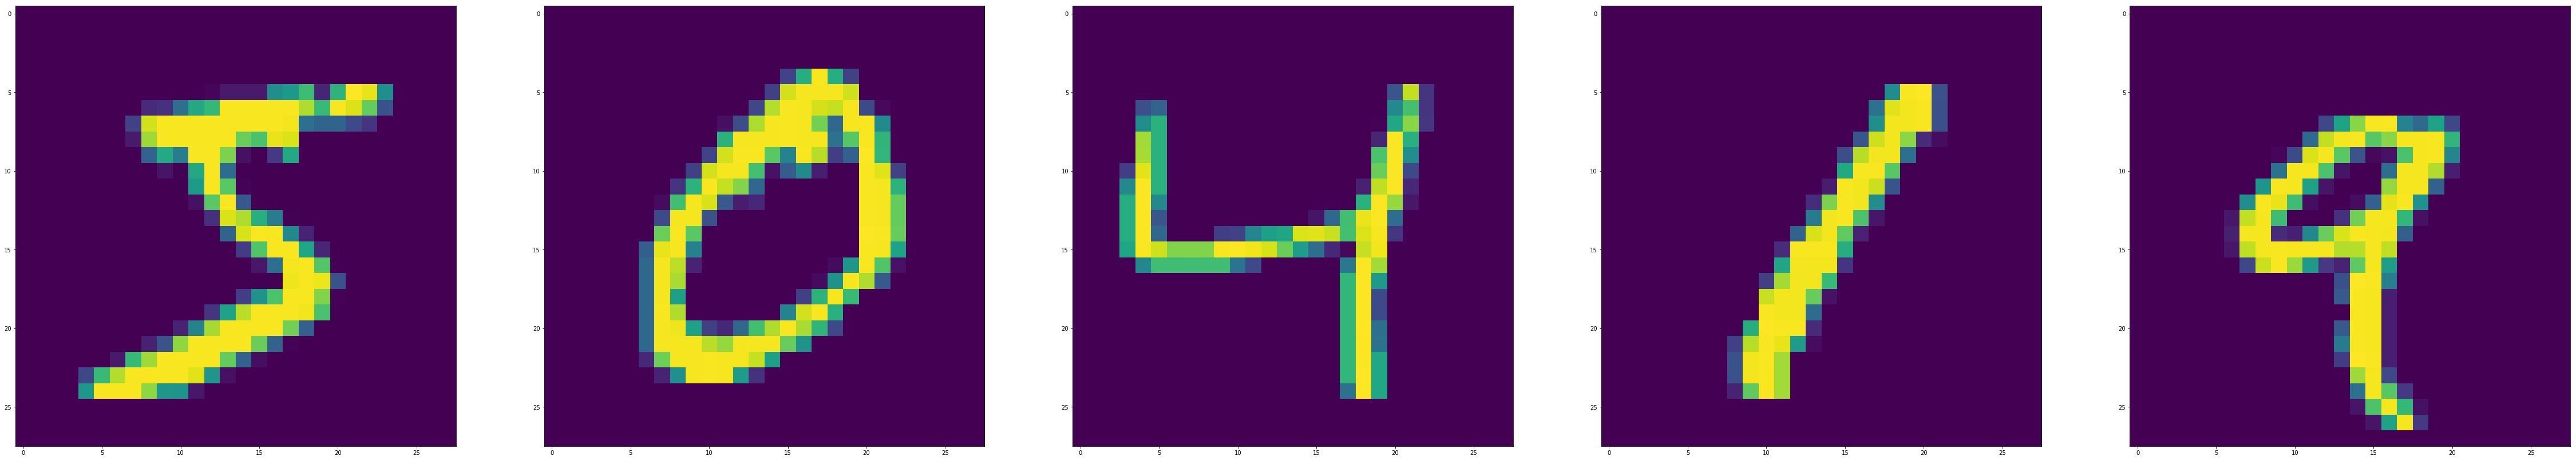

In [0]:
# Visualization of digits
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5):
    ax[i].imshow(x[i].reshape(28, 28))
plt.show()

In [0]:
def showDigit(datasetname, index):
    """Visualize specified digit"""
    pic1 = datasetname[index]
    pic1 = pic1.reshape((28, 28))
    %matplotlib inline
    plt.imshow(pic1, cmap='gray')
    plt.axis('off')

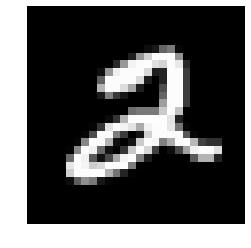

In [0]:
showDigit(images_tr, 5)

<a id="1"></a> 
# 2 Binary Classification

In [0]:
# build x2, y2, x2_tst, y2_tst.
seed = 1

# filtering the train dataset for binary classification (6 and 8)
y2 = labels_tr[(labels_tr == 6) | (labels_tr == 8)] 
# creat binary results (digit 6: 1, digit 8: 0)
y2 = [1 if each == 6 else 0 for each in y2 ]
y2 = np.array(y2)
y2 = np.expand_dims(y2, axis=1)
x2 = images_tr[(labels_tr == 6) | (labels_tr == 8)] 

# normalization 
x2 = x2 / 255 + 0.0001
x2 = np.array(x2)


y2_tst = labels_tst[(labels_tst == 6) | (labels_tst == 8)] 
y2_tst = [1 if each == 6 else 0 for each in y2_tst ]
y2_tst = np.array(y2_tst)
y2_tst = np.expand_dims(y2_tst, axis=1)

x2_tst = images_tst[(labels_tst == 6) | (labels_tst == 8)] 
x2_tst = np.array(x2_tst)

In [0]:
x2.shape, y2.shape, x2_tst.shape, y2_tst.shape

((11769, 784), (11769, 1), (1932, 784), (1932, 1))

## 2.1 Logistic Regression

In [0]:
def sigmoid(t):
    """apply sigmoid function on t."""
    s = 1 / (1 + np.exp(-t)) 
    
    return s

### 2.1.1 Gradient Descent

Current iteration = 0, loss = 0.6931471805599453
Current iteration = 100, loss = 0.058722723126093404
Current iteration = 200, loss = 0.047364361930839524
Current iteration = 300, loss = 0.0423798127405658
Current iteration = 400, loss = 0.03935863909332121
Current iteration = 500, loss = 0.037242470662113225
Current iteration = 600, loss = 0.035633129430896845
Current iteration = 700, loss = 0.03434319682092432
Current iteration = 800, loss = 0.03327129613809664
Current iteration = 900, loss = 0.03235705536901881
Current iteration = 1000, loss = 0.03156187504140458
Current iteration = 1100, loss = 0.030859685846572345
Current iteration = 1200, loss = 0.030232095902941573
Current iteration = 1300, loss = 0.02966566027470622
Current iteration = 1400, loss = 0.02915025649976845
Current iteration = 1500, loss = 0.02867807258800166
Current iteration = 1600, loss = 0.028242951654295228
Current iteration = 1700, loss = 0.027839953190804706
Current iteration = 1800, loss = 0.02746505078742758

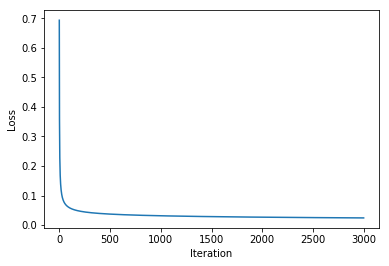

In [0]:
def getLoss(y, tx, w, lam):
    """compute loss and gradient"""
    n = y.shape[0]
    scores = np.dot(tx,w)
    p = sigmoid(scores)
    loss = (-1 / n) * np.sum((y * np.log(p) + (1 - y) * np.log(1 - p))) + (lam / 2) * np.sum(w * w) 
    grad = (-1 / n) * np.dot(tx.T, (y - p)) + lam / n * w

    return loss, grad


def logistic_regression_gradient_descent_demo_with_regularisation(y, x):
    """run logistic regression with gradient descent"""    
    startTime = time.time()

    lam = 0   
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))
    
    iteration = 3000
#     iteration = 5000
    learning_rate = 0.2
    threshold = 1e-8
    losses = []
    
    for iter in range(iteration):
        loss, grad = getLoss(y, tx, w, lam)
        w = w - learning_rate * grad
        w[0,1:] = w[0,1:] - lam * w[0,1:]

        if iter % 100 == 0:
            print("Current iteration = {i}, loss = {l}".format(i=iter, l=loss))
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    print('Time(s):',time.time() - startTime) 
    
    plt.plot(losses)
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    
    return w

w = logistic_regression_gradient_descent_demo_with_regularisation(y2, x2)

In [0]:
def getAccuracy(x, y, w):
    """compute accuracy"""  
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    preds = (sigmoid(tx.dot(w)) >= 0.5).astype(np.int)
    accuracy = (preds == y).mean()
    
    return accuracy, preds

In [0]:
accuracy,pred = getAccuracy(x2, y2, w)
act = y2
accuracy_tst, pred_tst = getAccuracy(x2_tst, y2_tst, w)
act_tst = y2_tst

In [0]:
print ('Training Accuracy (Binary, Gradient Descent):', accuracy)
print ('Test Accuracy (Binary, Gradient Descent):',accuracy_tst)

Training Accuracy (Binary, Gradient Descent): 0.9920978842722407
Test Accuracy (Binary, Gradient Descent): 0.9891304347826086


In [0]:
cm = metrics.confusion_matrix(act, pred)
print (cm)

[[5799   52]
 [  41 5877]]


<Figure size 360x360 with 0 Axes>

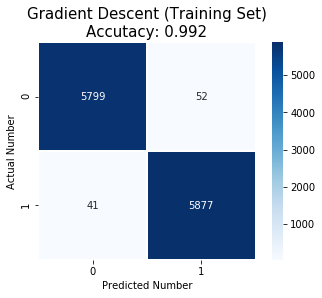

<Figure size 360x360 with 0 Axes>

In [0]:
sns.heatmap(cm, annot = True, fmt="d", linewidths=.5, square = True,cmap='Blues')
plt.ylabel('Actual Number')
plt.xlabel('Predicted Number')
score = round(accuracy,3)
plt.title("Gradient Descent (Training Set)\nAccutacy: {0}".format(score),size=15)
plt.figure(figsize=(5,5))

In [0]:
print(classification_report(act, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5851
           1       0.99      0.99      0.99      5918

   micro avg       0.99      0.99      0.99     11769
   macro avg       0.99      0.99      0.99     11769
weighted avg       0.99      0.99      0.99     11769



In [0]:
cm_tst = metrics.confusion_matrix(act_tst, pred_tst)
print (cm_tst)

[[964  10]
 [ 11 947]]


<Figure size 360x360 with 0 Axes>

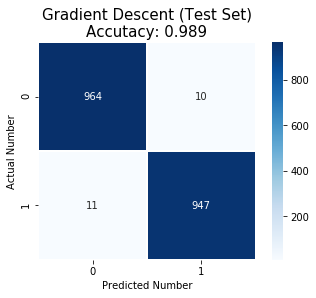

<Figure size 360x360 with 0 Axes>

In [0]:
sns.heatmap(cm_tst, annot = True, fmt="d", linewidths=.5, square = True,cmap='Blues')
plt.ylabel('Actual Number')
plt.xlabel('Predicted Number')
score = round(accuracy_tst,3)
plt.title("Gradient Descent (Test Set)\nAccutacy: {0}".format(score),size=15)
plt.figure(figsize=(5,5))

In [0]:
print(classification_report(act_tst, pred_tst))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       974
           1       0.99      0.99      0.99       958

   micro avg       0.99      0.99      0.99      1932
   macro avg       0.99      0.99      0.99      1932
weighted avg       0.99      0.99      0.99      1932



### 2.1.2 Newton's method

In [0]:
def inv(m):
    """inverse matrix"""  
    a, b = m.shape
    if a != b:
        raise ValueError("Square matrices are invertible.")
    i = np.eye(a, a)
    
    return np.linalg.lstsq(m, i)[0]

/Users/mei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


Current iteration=0, the loss=0.6931471805599453
Current iteration=1, the loss=0.17959800086327518
Current iteration=2, the loss=0.1015548747289658
Current iteration=3, the loss=0.06769134189416522
Current iteration=4, the loss=0.0497446194730493
Current iteration=5, the loss=0.03879063701379286
Current iteration=6, the loss=0.03157634002089508
Current iteration=7, the loss=0.027787493392680322
Time(s): 3.0069048404693604


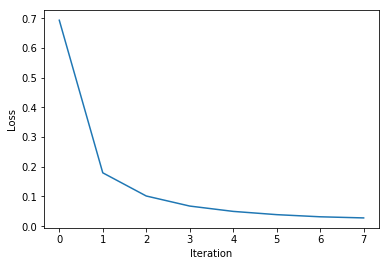

In [0]:
def getLoss_n(y, tx, w, lam):
    """return the loss and updated w"""
    n = y.shape[0]
    p = sigmoid(tx.dot(w))
    
    loss = (-1 / n) * np.sum((y * np.log(p) + (1 - y) * np.log(1 - p))) + (lam / 2) * np.sum(w * w)
    grad = (-1 / n) * np.dot(tx.T, (y - p))+ lam / n * w
    Sw = np.diag(p*(1-p)) 
    TXT=tx.T.dot(tx)   
    hessian = Sw * TXT/ y.shape[0] 
    
    w = w - np.dot(inv(hessian), grad)
    
    return loss, w


def logistic_regression_newton_method_demo(y, x):
    """run logistic regression with newton method"""      
    startTime = time.time()
    
    lam = 0
    iteration = 8  
    threshold = 1e-8
    losses = []

    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))
    w[0,1:] = w[0,1:] - lam * w[0,1:]
    
    for iter in range(iteration):
        loss, w = getLoss_n(y, tx, w, lam)
        if iter % 1 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    print('Time(s):',time.time() - startTime) 
    
    plt.plot(losses)
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    
    return w

w = logistic_regression_newton_method_demo(y2, x2)

In [0]:
accuracy_n,pred_n = getAccuracy(x2, y2, w)
act_n = y2
accuracy_tst_n, pred_tst_n = getAccuracy(x2_tst, y2_tst, w)
act_tst_n = y2_tst

In [0]:
print ('Training Accuracy (Binary, Newton):', accuracy_n)
print ('Test Accuracy (Binary, Newton):',accuracy_tst_n)

Training Accuracy (Binary, Newton): 0.9944770158892005
Test Accuracy (Binary, Newton): 0.984472049689441


In [0]:
cm_n = metrics.confusion_matrix(act_n, pred_n)
print (cm_n)

[[5832   19]
 [  46 5872]]


<Figure size 360x360 with 0 Axes>

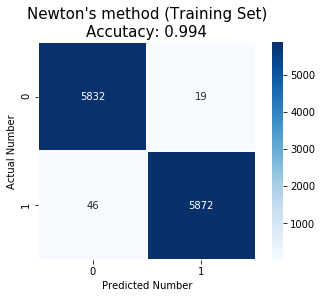

<Figure size 360x360 with 0 Axes>

In [0]:
sns.heatmap(cm_n, annot = True, fmt="d", linewidths=.5, square = True,cmap='Blues')
plt.ylabel('Actual Number')
plt.xlabel('Predicted Number')
score = round(accuracy_n,3)
plt.title("Newton's method (Training Set)\nAccutacy: {0}".format(score),size=15)
plt.figure(figsize=(5,5))

In [0]:
print(classification_report(act_n, pred_n))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5851
           1       1.00      0.99      0.99      5918

   micro avg       0.99      0.99      0.99     11769
   macro avg       0.99      0.99      0.99     11769
weighted avg       0.99      0.99      0.99     11769



In [0]:
cm_tst_n = metrics.confusion_matrix(act_tst_n, pred_tst_n)
print (cm_tst_n)

[[962  12]
 [ 18 940]]


<Figure size 360x360 with 0 Axes>

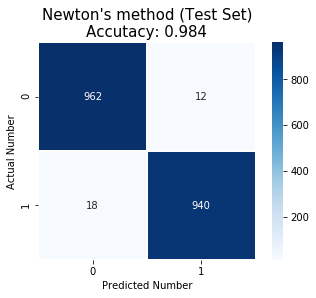

<Figure size 360x360 with 0 Axes>

In [0]:
sns.heatmap(cm_tst_n, annot = True, fmt="d", linewidths=.5, square = True,cmap='Blues')
plt.ylabel('Actual Number')
plt.xlabel('Predicted Number')
score = round(accuracy_tst_n,3)
plt.title("Newton's method (Test Set)\nAccutacy: {0}".format(score),size=15)
plt.figure(figsize=(5,5))

In [0]:
print(classification_report(act_tst_n, pred_tst_n))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       974
           1       0.99      0.98      0.98       958

   micro avg       0.98      0.98      0.98      1932
   macro avg       0.98      0.98      0.98      1932
weighted avg       0.98      0.98      0.98      1932



## 2.2 Scikit-learn

In [0]:
clf = LogisticRegression()

In [0]:
clf.fit(x2,y2)

/Users/mei/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mei/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
pridictions = clf.predict(x2_tst)
pridictions

array([1, 1, 1, ..., 1, 0, 1])

In [0]:
score = clf.score(x2_tst,y2_tst)
score

0.9906832298136646

In [0]:
cm_sk = metrics.confusion_matrix(y2_tst,pridictions)
print (cm)

[[5799   52]
 [  41 5877]]


<Figure size 360x360 with 0 Axes>

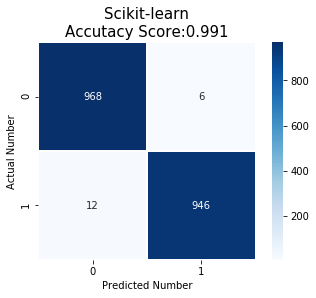

<Figure size 360x360 with 0 Axes>

In [0]:
sns.heatmap(cm_sk, annot = True, fmt="d", linewidths=.5, square = True,cmap='Blues')
plt.ylabel('Actual Number')
plt.xlabel('Predicted Number')
score = round(score,3)
plt.title('Scikit-learn\nAccutacy Score:{0}'.format(score),size=15)
plt.figure(figsize=(5,5))

<a id="2"></a> 

# 3 Multi-class Classification

In [0]:
# training set
y = labels_tr
x = images_tr
# test set
y_tst = labels_tst
x_tst = images_tst

In [0]:
x.shape, y.shape, x_tst.shape, y_tst.shape

((60000, 784), (60000,), (10000, 784), (10000,))

## 3.1 Logistic Regression

In [0]:
def softmax(t):
    """apply softmax function on t"""    
    t -= np.max(t)
    sm = (np.exp(t).T / np.sum(np.exp(t),axis=1)).T
    
    return sm

In [0]:
def oneHot(Y):
    """convert matrix into One-hot format"""     
    tx = x.shape[0]
    OHX = scipy.sparse.csr_matrix((np.ones(tx), (Y, np.array(range(tx)))))
    OHX = np.array(OHX.todense()).T
    
    return OHX

Current iteration=0, the loss=3.2508297339144794
Current iteration=10, the loss=1.2282151204046454
Current iteration=20, the loss=0.9250903571261738
Current iteration=30, the loss=0.8237724840728853
Current iteration=40, the loss=0.7663744870587302
Current iteration=50, the loss=0.7277167043699141
Current iteration=60, the loss=0.6994447511977002
Current iteration=70, the loss=0.6776187305090304
Current iteration=80, the loss=0.6601107758382039
Current iteration=90, the loss=0.6456601714416017
Current iteration=100, the loss=0.6334672236242903
Current iteration=110, the loss=0.6229973302826887
Current iteration=120, the loss=0.6138778898553942
Current iteration=130, the loss=0.605840248962228
Current iteration=140, the loss=0.5986851738888276
Current iteration=150, the loss=0.5922613659655663
Current iteration=160, the loss=0.5864515771078895
Current iteration=170, the loss=0.5811633425808717
Current iteration=180, the loss=0.5763226208657839
Current iteration=190, the loss=0.571869321

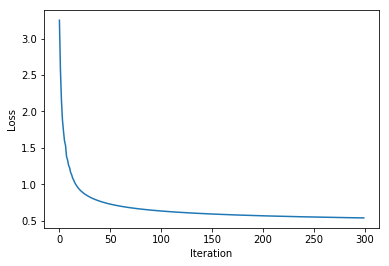

In [0]:
def getLoss_multi(w,x,y,lam):
    """compute loss and gradient"""
    n = y.shape[0] 
    y = oneHot(y) 
    scores = np.dot(x,w)   
    p = softmax(scores)   
    loss = (-1 / n) * np.sum((y * np.log(p) + (1 - y) * np.log(1 - p))) + (lam/2)*np.sum(w*w)
    grad = (-1 / n) * np.dot(x.T,(y - p)) + lam / n * w 
    
    return loss,grad


def softmax_regression_gradient_descent_demo(y, x):
    """run softmax regression with gradient descent"""     
    startTime = time.time()
    
    w = np.zeros([x.shape[1],len(np.unique(y))])
    
    lam = 0
    
    iteration = 300 
    learning_rate = 1e-5
    threshold = 1e-8
    losses = []

    for iter in range(iteration):
        loss, grad = getLoss_multi(w,x,y,lam)
        w = w - (learning_rate * grad) 
        w[0,1:] = w[0,1:] - lam * w[0,1:]
        if iter % 10 == 0:
            print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
        losses.append(loss)   
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break  
    print('Time(s):',time.time() - startTime)    

    plt.plot(losses)
    plt.ylabel('Loss')
    plt.xlabel('Iteration')
    
    return w

w = softmax_regression_gradient_descent_demo(y, x)

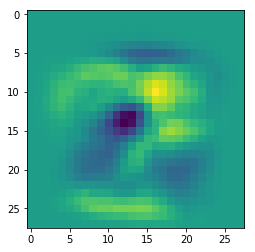

In [0]:
classWeightsToVisualize = 7
plt.imshow(scipy.reshape(w[:,classWeightsToVisualize],[28,28]))

In [0]:
def getProbsAndPreds_multi(x):
    """compute prob and pred"""    
    prob = softmax(np.dot(x,w))
    pred = np.argmax(prob,axis=1)
    
    return prob, pred

In [0]:
def getAccuracy_multi(x,y):
    """compute accuracy"""  
    prob,pred = getProbsAndPreds_multi(x)
    accuracy = sum(pred == y)/(float(len(y)))
    
    return accuracy,prob,pred

In [0]:
accuracy_multi,prob_multi,pred_multi = getAccuracy_multi(x,y)
act_multi = y
accuracy_tst_multi,prob_tst_multi,pred_tst_multi = getAccuracy_multi(x_tst,y_tst)
act_tst_multi = y_tst

In [0]:
print ('Training Accuracy (Multi-class, Gradient Descent):', accuracy_multi)
print ('Test Accuracy of (Multi-class, Gradient Descent):',accuracy_tst_multi)

Training Accuracy (Multi-class, Gradient Descent): 0.9107666666666666
Test Accuracy of (Multi-class, Gradient Descent): 0.9143


In [0]:
cm_multi = metrics.confusion_matrix(act_multi, pred_multi)
print (cm_multi)

[[5715    0   25   15   12   39   46    7   56    8]
 [   1 6525   33   30    6   34    7   18   79    9]
 [  46   66 5244   93  110   22   92   92  163   30]
 [  24   30  142 5416    4  222   34   68  127   64]
 [  12   33   34    6 5406    5   64   10   37  235]
 [  91   39   46  204   70 4563  110   25  199   74]
 [  36   21   49    4   49   79 5628    5   46    1]
 [  35   55   89   22   68    8    4 5749   16  219]
 [  32  132   70  147   24  164   51   25 5111   95]
 [  35   32   30   88  193   33    5  186   58 5289]]


Text(0.5, 1.0, 'Gradient descent (Training Set)\nAccutacy: 0.911')

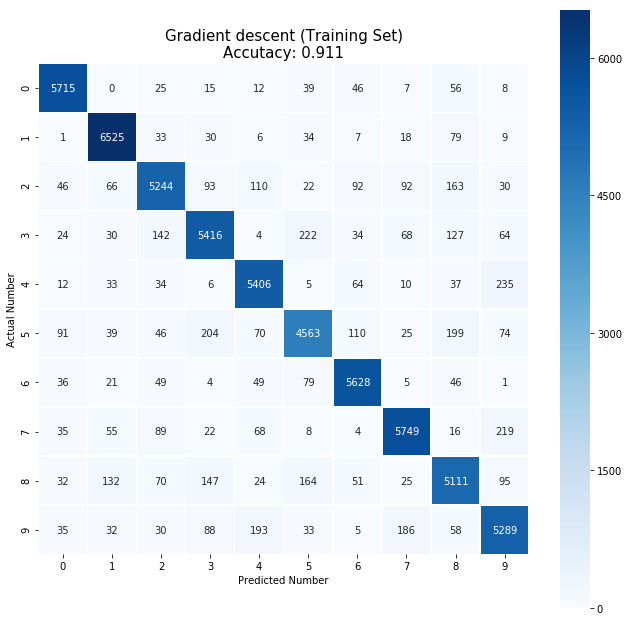

In [0]:
plt.figure(figsize=(11,11))
sns.heatmap(cm_multi, annot = True, fmt="d", linewidths=.5, square = True,cmap='Blues')
plt.ylabel('Actual Number')
plt.xlabel('Predicted Number')
score = round(accuracy_multi,3)
plt.title("Gradient descent (Training Set)\nAccutacy: {0}".format(score),size=15)

In [0]:
print(classification_report(act_multi, pred_multi))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      5923
           1       0.94      0.97      0.95      6742
           2       0.91      0.88      0.89      5958
           3       0.90      0.88      0.89      6131
           4       0.91      0.93      0.92      5842
           5       0.88      0.84      0.86      5421
           6       0.93      0.95      0.94      5918
           7       0.93      0.92      0.92      6265
           8       0.87      0.87      0.87      5851
           9       0.88      0.89      0.88      5949

   micro avg       0.91      0.91      0.91     60000
   macro avg       0.91      0.91      0.91     60000
weighted avg       0.91      0.91      0.91     60000



In [0]:
accuracy_tst_multi,prob_tst_multi,pred_tst_multi = getAccuracy_multi(x_tst,y_tst)
act_tst_multi = y_tst

In [0]:
act_tst_multi.shape, pred_tst_multi.shape

((10000,), (10000,))

In [0]:
cm_tst_multi = metrics.confusion_matrix(act_tst_multi, pred_tst_multi)
print (cm_tst_multi)

[[ 959    0    2    2    0    4    9    1    3    0]
 [   0 1107    2    3    1    3    4    1   14    0]
 [  10    6  905   16   14    2   13   16   42    8]
 [   3    0   22  911    0   29    3   11   20   11]
 [   1    2    4    1  916    0   12    2    8   36]
 [  10    4    3   38   11  755   16    9   38    8]
 [  13    3    3    3   12   12  908    1    3    0]
 [   3   12   24    7    8    0    0  937    4   33]
 [   6   10    8   25    9   28   13   13  851   11]
 [  11    7    3   11   43    9    0   24    7  894]]


Text(0.5, 1.0, 'Gradient descent (Test Set)\nAccutacy: 0.914')

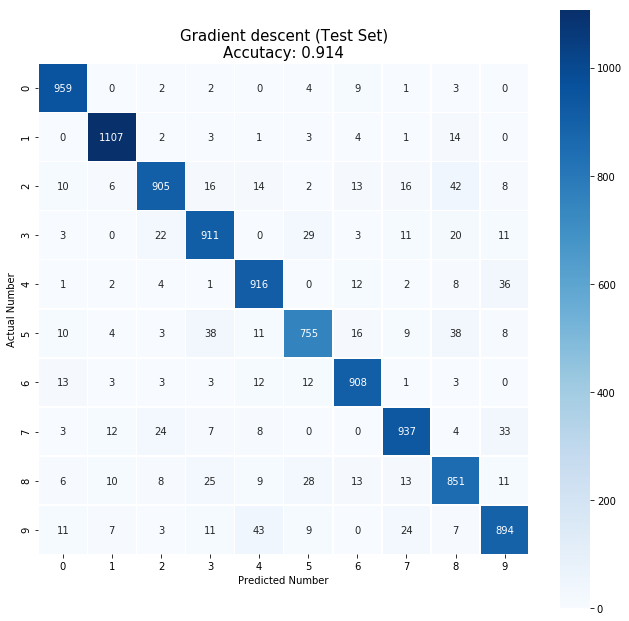

In [0]:
plt.figure(figsize=(11,11))
# sns.heatmap(cm, annot = True, fmt=".3f", linewidths=.5, square = True,camp='Blues')
sns.heatmap(cm_tst_multi, annot = True, fmt="d", linewidths=.5, square = True,cmap='Blues')
plt.ylabel('Actual Number')
plt.xlabel('Predicted Number')
score = round(accuracy_tst_multi,3)
plt.title("Gradient descent (Test Set)\nAccutacy: {0}".format(score),size=15)

In [0]:
print(classification_report(act_tst_multi, pred_tst_multi))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.88      0.90      1032
           3       0.90      0.90      0.90      1010
           4       0.90      0.93      0.92       982
           5       0.90      0.85      0.87       892
           6       0.93      0.95      0.94       958
           7       0.92      0.91      0.92      1028
           8       0.86      0.87      0.87       974
           9       0.89      0.89      0.89      1009

   micro avg       0.91      0.91      0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



<a id="10"></a> 
## Conclusion

* Accuracy <br/>


In [0]:
print ('Training Accuracy (Binary, Gradient Descent):', accuracy)
print ('Test Accuracy (Binary, Gradient Descent):',accuracy_tst)

Training Accuracy (Binary, Gradient Descent): 0.9920978842722407
Test Accuracy (Binary, Gradient Descent): 0.9891304347826086


In [0]:
print ('Training Accuracy (Binary, Newton):', accuracy_n)
print ('Test Accuracy (Binary, Newton):',accuracy_tst_n)

Training Accuracy (Binary, Newton): 0.9944770158892005
Test Accuracy (Binary, Newton): 0.984472049689441


In [0]:
print ('Training Accuracy (Multi-class, Gradient Descent):', accuracy_multi)
print ('Test Accuracy of (Multi-class, Gradient Descent):',accuracy_tst_multi)

Training Accuracy (Multi-class, Gradient Descent): 0.9107666666666666
Test Accuracy of (Multi-class, Gradient Descent): 0.9143
